# Imports

In [1]:
import numpy as np
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import re
import nltk

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# Reading the data

In [3]:
data_train = pd.read_csv('./data/morph_train.tsv', delimiter='\t', header=None, quoting=3, names=['text', 'numeric_label'])
data_train['type'] = 'train'
data_test = pd.read_csv('./data/morph_test.tsv', delimiter='\t', header=None, quoting=3, names=['text', 'numeric_label'])
data_test['type'] = 'test'


# Cleaning the data

## Stopwords

In [4]:
# Importing Hebrew stopword collection
#######################
heb_stopwords = list(pd.read_csv('heb_stopwords.txt').values.squeeze())
important_words_to_keep = ['גרוע','לא','טוב','רע','אין','יפה','שמח','מאמין']
for word in important_words_to_keep:
    if word in heb_stopwords:
        heb_stopwords.remove(word)
stop_words_to_add = ['את']
for word in stop_words_to_add:
    if word not in heb_stopwords:
        heb_stopwords.append(word)
#######################
def remove_stopwords(df, stopwords):
# Removing Stop words from the data

    for i, line in enumerate(df):
        line = ' '.join([word for word in line.split() if word not in stopwords])
        df.loc[i] = line
    return df

## Keeping only hebrew and emojies

In [5]:
def keep_only_hebrew_and_emoj(df):
# Keeping only hebrew and emojies 

    # Defining regex to replace and keep in the docs, all excluded will be removed
    reg =  "".join(["[^",  
     "\u0590-\u05FF",            # Hebrew
      "\U0001F1E0-\U0001F1FF",    # flags (iOS)
      "\U0001F300-\U0001F5FF",    # symbols & pictographs
      "\U0001F600-\U0001F64F",    # emoticons
      "\U0001F680-\U0001F6FF",    # transport & map symbols
      "\U0001F700-\U0001F77F",    # alchemical symbols
      "\U0001F780-\U0001F7FF",    # Geometric Shapes Extended
      "\U0001F800-\U0001F8FF",    # Supplemental Arrows-C
      "\U0001F900-\U0001F9FF",    # Supplemental Symbols and Pictographs
      "\U0001FA00-\U0001FA6F",    # Chess Symbols
      "\U0001FA70-\U0001FAFF",    # Symbols and Pictographs Extended-A
      "\U00002702-\U000027B0",    # Dingbats
      "\U000024C2-\U0001F251", 
    "]"])
    sad_smilies = ":\(|\):|: \(|\) :|🤔|🤨|😐|😑|🙄|😣|😥|😮|🤐|😯|😪|😫|🥱|😒|😓|😔|😕|☹|🙁|😖|😞|😟|😤|😢|😭|😦|😧|😨|😩|🤯|😬|😰|😱|🥵|🥶|😳|😵|😠|😡|🤬|😷|🤒|🤕|🤢|🤮|🤧|🥺|🤥|👿|👺|☠"
    happy_smilies = ":\)|\(:|: \)|\( :|😀|😁|😂|🤣|😃|😄|😅|😆|😉|😊|😋|😎|😍|😘|🥰|😙|😚|😗|☺|🙂|🤗|🤩|😏|😇|🥳|😛|😜|😝|🤤|🤑|🤪|🤠|🤡|🤭|🧐|🤓|💑|👩‍❤️‍👩|👨‍❤️‍👨|💏|👩‍❤️‍💋‍👩|👨‍❤️‍💋‍👨"
    regex_pattern = re.compile(reg)
    
    for i, line in enumerate(df):
        line = re.sub(sad_smilies, '🙁', line)
        line = re.sub(happy_smilies, '😀', line)
        line = re.sub(reg, ' ', line)
        df.loc[i] = line
    return df

In [6]:
# Testing Re
pd_testing_re = pd.DataFrame(np.array(['abc אבג'
                                       ,'שלום מה נשמע abc DEF (גבר) :) :) :( ! 😛 😁👍👍🤞😎😢🎉🐱‍👓😢✔👨‍🦰🤶🤦‍♀️😉 '
                                       , 'אבג גבד אאא', 'abc def', '👍🤞😎'
                                       , ': ) ): hello שלום tשbב']))
pd_testing_re.columns=['before']


pd_testing_re['after'] = keep_only_hebrew_and_emoj(pd_testing_re['before'].copy())
pd_testing_re

,before,after
0,abc אבג,אבג
1,שלום מה נשמע abc DEF (גבר) :) :) :( ! 😛 😁👍👍🤞😎😢...,שלום מה נשמע גבר🙁🙁🙁 😀 😀👍👍🤞😀🙁🎉🐱 👓🙁✔...
2,אבג גבד אאא,אבג גבד אאא
3,abc def,
4,👍🤞😎,👍🤞😀
5,: ) ): hello שלום tשbב,😀 🙁 שלום ש ב


## Adding textual labels: 'posotive', 'negative' and 'neutral'

In [7]:
label_dic = {0 : 'positive', 1 : 'negative', 2 : 'neutral'}

## Running the cleaning functions

In [8]:
def df_cleaner(df, stopwords=heb_stopwords ):
    df['text'] = remove_stopwords(df['text'].copy(), stopwords)
    df['text'] = keep_only_hebrew_and_emoj(df['text'].copy())
    df['label'] = df['numeric_label'].apply(lambda label: label_dic[label])
    return df
    
# Training set:
data_train = df_cleaner(data_train)
# Test set:
data_test = df_cleaner(data_test)


In [9]:
data_train.head()

,text,numeric_label,type,label
0,כואב בכה משפחה לא תדעו צער,0,train,positive
1,איש יקר,0,train,positive
2,כבוד הצלחה,0,train,positive
3,תל חי רובי עצב היית אור תקוה אכן נשיא,0,train,positive
4,נקי כפיים לבב הצלחה,0,train,positive


In [10]:
data_test.head()

,text,numeric_label,type,label
0,שמע ישמור יקרא גורל י ק ו ק אימרו ...,0,test,positive
1,איחולי הצלחה תפקידך,0,test,positive
2,כבוד,0,test,positive
3,טוב טוב לכבוד נשיא מדינת ״ אשרי נבחר עשיר ...,0,test,positive
4,גינוי ...,1,test,negative


# Perform vectorization transformation using sklearn

## Helper functions

In [11]:
def choose_vectorizer(transform_type='tfidf', max_features=5000):
    if transform_type=='tfidf':
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(use_idf=True, stop_words=heb_stopwords, max_features=max_features)#, min_df=20, max_df=100)
    elif transform_type=='bow':
        
        vectorizer = CountVectorizer(stop_words=heb_stopwords, max_features=max_features)
    else:
        vectorizer = None
        
    return vectorizer

def choose_classifier(classification_type='logistic'):
    if classification_type == 'logistic':
        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression()

    elif classification_type == 'nb':
        from sklearn.naive_bayes import GaussianNB
        classifier = GaussianNB()
    else:
        classifier = None
    
    return classifier   

In [12]:
vectorizer = choose_vectorizer('tfidf', max_features=900)
X_train = vectorizer.fit_transform(data_train['text']).toarray()
y_train = data_train['numeric_label']
X_test = vectorizer.transform(data_test['text']).toarray()
y_test = data_test['numeric_label']

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10244, 900) (10244,)
(2560, 900) (2560,)


# Training the classifier

In [14]:
classifier = choose_classifier('logistic')
classifier.fit(X_train, y_train)

LogisticRegression()

# Making a confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)
accuracy_score(y_train, y_pred_train)

[[6471  340    3]
 [ 619 2511    2]
 [ 147   94   57]]


0.8823701679031628

In [16]:
y_pred_test = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
accuracy_score(y_test, y_pred_test)

[[1594  104    0]
 [ 212  577    1]
 [  32   31    9]]


0.8515625

<AxesSubplot:>

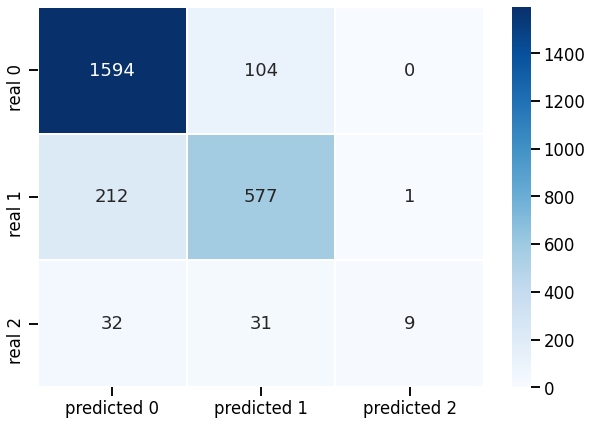

In [17]:
import seaborn as sn
sn.set_context("talk", font_scale=1.0)
df_cm = pd.DataFrame(cm_test, index = ['real 0', 'real 1', 'real 2'],
                  columns = ['predicted 0', 'predicted 1', 'predicted 2'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", linewidths=2, fmt='g')

# Some manual checks

In [18]:
manual_check_list = ['😠😠😠🥺 הנשיא ריבלין הוא אידיוט לא מאמין שהצבעתי לך'
         ,'הנשיא הזה הוא בחירה גרועה'
         ,'אני אוהב אותך נשיא יקר'
         ,'זה פשוט חלום אחלה של נזשיא בהצלחה מרובה'
         ,'אכזבה ממישהו שציפיתי שיגיד דעה חדה וברורה מתבייש בך רובי , אכזבת אותי'
         ,'תומך במחבלים שמאלני'
         ,'משפט כללי ללא סיווג ודאי'
         ,'אחלה נשיא נכנס לתפקיד, מצפה להצלחות מרובות'              
         ]
manual_y = np.array([1, 1, 0, 0, 1, 1, 2, 0])
manual_df = pd.DataFrame({'text': manual_check_list, 'numeric_label' : manual_y})

manual_df = df_cleaner(manual_df)

X_manual = vectorizer.transform(manual_df['text']).toarray()
y_manual = manual_df['numeric_label']
y_manual_pred = classifier.predict(X_manual)

In [19]:
for line, y, y_pred in zip(manual_df['text'] , y_manual, y_manual_pred):
    print(f'{line:>70}-{label_dic[y]:^10}-{label_dic[y_pred]:^10}')
    print('-'*120)

                             🙁🙁🙁🙁 הנשיא ריבלין אידיוט לא מאמין שהצבעתי- negative - negative 
------------------------------------------------------------------------------------------------------------------------
                                                     הנשיא בחירה גרועה- negative - positive 
------------------------------------------------------------------------------------------------------------------------
                                                              נשיא יקר- positive - positive 
------------------------------------------------------------------------------------------------------------------------
                                                      אחלה נזשיא מרובה- positive - positive 
------------------------------------------------------------------------------------------------------------------------
      אכזבה ממישהו שציפיתי שיגיד דעה חדה וברורה מתבייש בך רובי   אכזבת- negative - negative 
---------------------------------------------------

# Reviewing the results

In [20]:
from bidi.algorithm import get_display
feature_names = vectorizer.get_feature_names()
feature_names_inveted = [get_display(word) for word in feature_names]
importances = classifier.coef_
sorted_importances = []
for i in range(3):
    zipped_lists = zip(importances[i], feature_names_inveted)
    sorted_importances.append(dict(sorted(zipped_lists)[::-1]))    

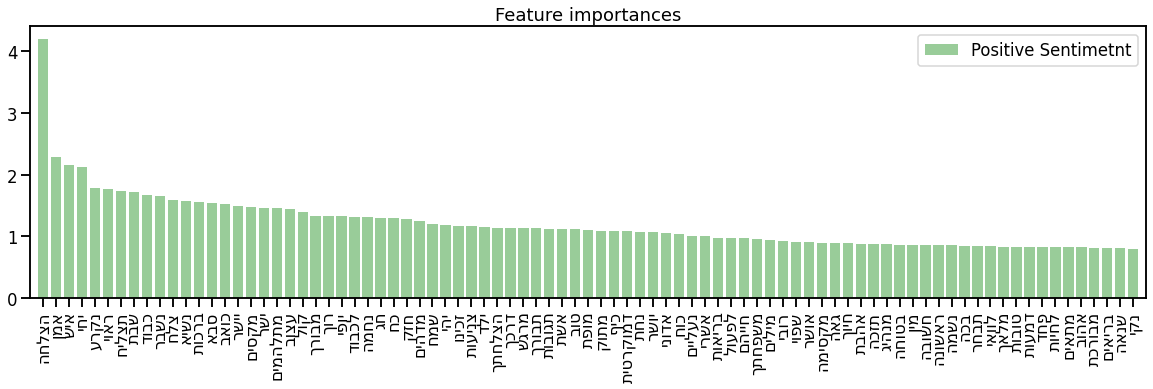

In [21]:
feature_count = 85
plt.figure(figsize = (20,5))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances[0].keys())[:feature_count], color="g", align="center", label='Positive Sentimetnt', alpha=0.4)
plt.xticks(range(feature_count), list(sorted_importances[0].values())[:feature_count], rotation=90)
plt.xlim([-1, feature_count])
plt.legend()
plt.show()

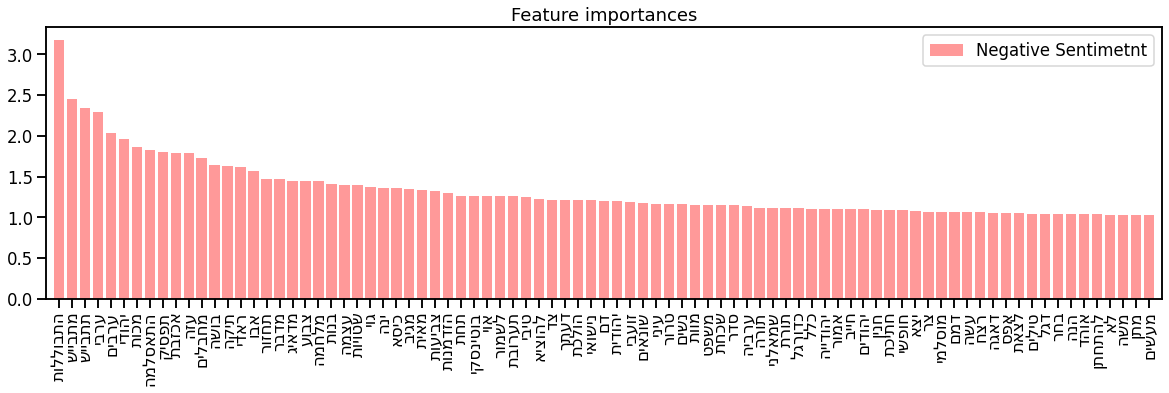

In [22]:
plt.figure(figsize = (20,5))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances[1].keys())[:feature_count], color="r", align="center", label='Negative Sentimetnt', alpha=0.4)
plt.xticks(range(feature_count), list(sorted_importances[1].values())[:feature_count], rotation=90)
plt.xlim([-1, feature_count])
plt.legend()
plt.show()

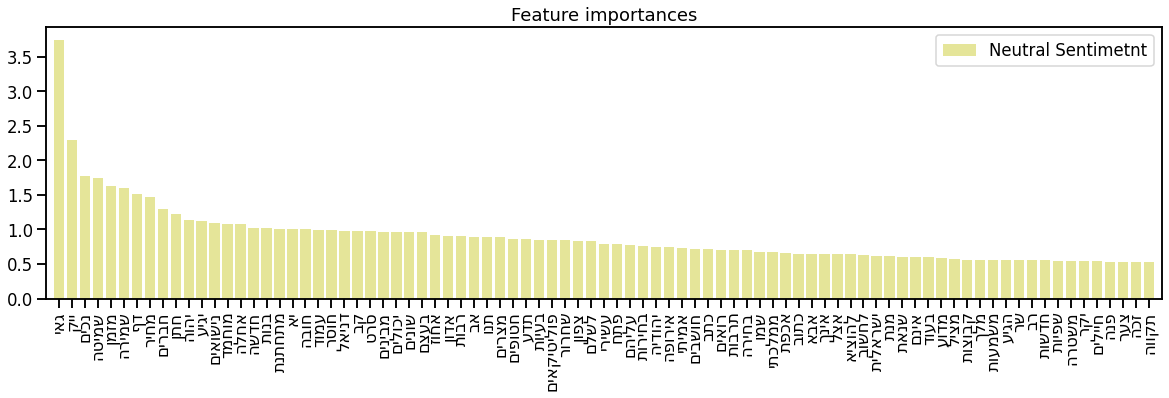

In [23]:
plt.figure(figsize = (20,5))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances[2].keys())[:feature_count], color="y", align="center", label='Neutral Sentimetnt', alpha=0.4)
plt.xticks(range(feature_count), list(sorted_importances[2].values())[:feature_count], rotation=90)
plt.xlim([-1, feature_count])
plt.legend()
plt.show()

In [24]:
data_master = pd.concat([data_train, data_test], ignore_index = True)

In [25]:
positive_mask = data_master.label == 'positive'
negative_mask = data_master.label == 'negative'
neutral_mask = data_master.label == 'neutral'
data_master

,text,numeric_label,type,label
0,כואב בכה משפחה לא תדעו צער,0,train,positive
1,איש יקר,0,train,positive
2,כבוד הצלחה,0,train,positive
3,תל חי רובי עצב היית אור תקוה אכן נשיא,0,train,positive
4,נקי כפיים לבב הצלחה,0,train,positive
...,...,...,...,...
12799,...,2,test,neutral
12800,גאה משפחתך נהדרת,0,test,positive
12801,קרה נהיית נשיא נהיית פרס תתעסק הסתות ערבים ת...,1,test,negative
12802,כבוד נשיא נבחר התרגשתי אתמול נאומך עצרת הזדה...,0,test,positive


In [26]:
cv_pos = CountVectorizer(analyzer='word')
cv_neg = CountVectorizer(analyzer='word')
cv_neu = CountVectorizer(analyzer='word')

vect_pos = cv_pos.fit_transform(data_master[positive_mask].text).toarray()
vect_neg = cv_neg.fit_transform(data_master[negative_mask].text).toarray()
vect_neu = cv_neu.fit_transform(data_master[neutral_mask].text).toarray()

df_pos_freq = pd.DataFrame({'frequency' : vect_pos.sum(axis=0)} , index=list(cv_pos.get_feature_names()) )
df_neg_freq = pd.DataFrame({'frequency' : vect_neg.sum(axis=0)} , index=list(cv_neg.get_feature_names()) )
df_neu_freq = pd.DataFrame({'frequency' : vect_neu.sum(axis=0)} , index=list(cv_neu.get_feature_names()) )

In [27]:
# POSITIVE WORDS #
df_pos_freq.nlargest(15, 'frequency')

,frequency
נשיא,3998
כבוד,1862
הצלחה,1749
לא,1490
רובי,944
מדינת,713
מדינה,711
טוב,663
ריבלין,624
יקר,550


In [28]:
# NEGATIVE WORDS #
df_neg_freq.nlargest(15, 'frequency')

,frequency
לא,3582
נשיא,2026
מדינה,782
כבוד,690
יהודי,686
התבוללות,634
יהודים,533
אין,516
מדינת,474
ערבים,449


In [29]:
# NEUTRAL WORDS #
df_neu_freq.nlargest(15, 'frequency')

,frequency
לא,222
נשיא,43
אין,36
כש,35
גאי,28
נהיגה,28
ייק,25
טוב,24
כבוד,24
נכים,24


CROSS CLASS TOP (15) WORDS:

|word |Positive |Negative | Neutral |
|:----:|:-------:|:-------:|:-------:|
|**נשיא**| +    |  +    |  +      |
|**כבוד**| +        |   +    |  +      |
|הצלחה  | +        |        |        |
|**לא** | +        |   +    |   +    |
|  **רובי** | +        |   +    |        |
|**מדינת**  | +        |   +    |        |
|**מדינה**  | +        |   +    |        |
| **טוב ** | +        |        |    +   |
|**ריבלין**| +        |   +    |        |
| יקר   | +        |        |        |
|  איש | +        |         |        |
|**אין** | +        |   +     |    +   |
| אדוני   | +        |        |       |
| אמן   | +        |        |       |
| ראוי   | +        |        |       |
| יהודי   |         |   +     |       |
| התבוללות|         |   +     |       |
| יהודים  |         |   +     |       |
| ערבים  |         |   +     |       |
| ערבי   |         |   +     |       |
| בושה   |         |   +     |       |
| עולם   |         |   +     |       |
| כש   |         |         |  +     |
| גאי   |         |         |  +     |
| נהיגה   |         |         |  +     |
| ייק   |         |         |  +     |
| נכים   |         |         |  +     |
| צפון   |         |         |  +     |
| דף   |         |         |  +     |
| יגיע   |         |         |  +     |
| ממשלה   |         |         |  +     |
| שמירה   |         |         |  +     |















# WordCloud

In [30]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from bidi.algorithm import get_display
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");

In [31]:
positive_text=" ".join(data_master[positive_mask].text)
negative_text=" ".join(data_master[negative_mask].text)
neutral_text=" ".join(data_master[neutral_mask].text)


Positive review words:


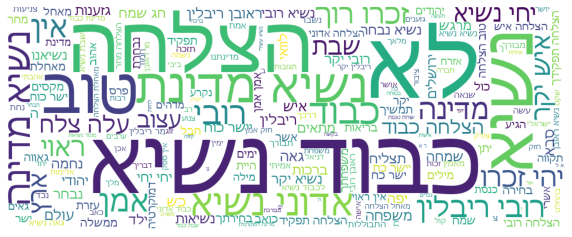

In [52]:
print('Positive review words:')
bidi_text = get_display(positive_text)
wordcloud = WordCloud(font_path='./tahoma.ttf',width = 1000, height = 400, background_color='white').generate(bidi_text)
plot_cloud(wordcloud)

Negative review words:


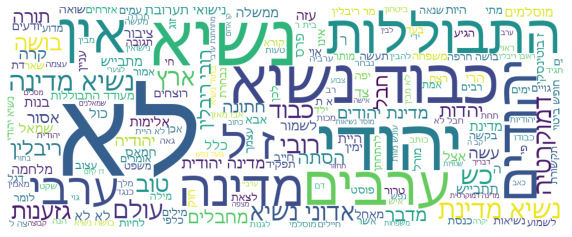

In [53]:
print('Negative review words:')
bidi_text = get_display(negative_text)
wordcloud = WordCloud(font_path='./tahoma.ttf',width = 1000, height = 400, background_color='white').generate(bidi_text)
plot_cloud(wordcloud)

Neutral review words:


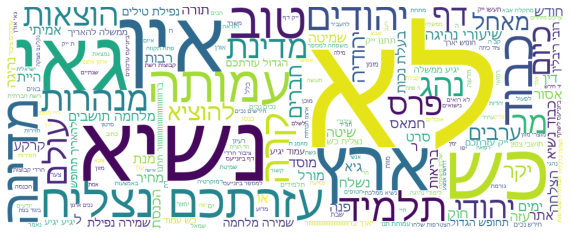

In [54]:
print('Neutral review words:')
bidi_text = get_display(neutral_text)
wordcloud = WordCloud(font_path='./tahoma.ttf',width = 1000, height = 400, background_color='white').generate(bidi_text)
plot_cloud(wordcloud)

We can see that there are some words that are very frequent in multiple classess hence shoud be marked as stopwords:\
נשיא, כבוד, לא, רובי, מדינת, מדינה, טוב, ריבלין, אין

We can also see some words that may be joined as a single feature:\
מדינת == מדינה, יהודי == יהודים, ערבי == ערבים 

In [33]:
feature_names = vectorizer.get_feature_names()
importances = classifier.coef_

In [34]:
importances_df = pd.DataFrame({'features' : feature_names, 'positive' : importances[0], 'negative' : importances[1], 'neutral' : importances[2]})
importances_df.set_index('features', inplace=True)

In [35]:
# Positive top features
importances_df.nlargest(15, 'positive')['positive']

features
הצלחה    4.194114
אמן      2.280072
איש      2.163971
יחי      2.132840
נקרע     1.783418
ראוי     1.771504
תצליח    1.730460
שבת      1.715499
כבוד     1.671928
נשבר     1.649164
צלח      1.598281
נשיא     1.572784
ברכות    1.555516
סבא      1.547513
כואב     1.525162
Name: positive, dtype: float64

In [36]:
# Negative top features
importances_df.nlargest(15, 'negative')['negative']

features
התבוללות    3.177795
מתבייש      2.453890
תתבייש      2.339801
ערבי        2.292010
ערבים       2.032652
יהודי       1.957063
מכות        1.865456
התאסלמה     1.825389
תפסיק       1.805333
אכזבת       1.793116
עזה         1.783847
מחבלים      1.727297
בושה        1.645892
תיקה        1.633063
ראדי        1.618505
Name: negative, dtype: float64

In [37]:
importances_df.nlargest(15, 'neutral')['neutral']

features
גאי        3.746675
ייק        2.288370
נכים       1.767027
שמיטה      1.745089
מזמן       1.635580
שמירה      1.599929
דף         1.506888
מחיר       1.468902
חברים      1.289815
חתן        1.216796
יהוה       1.136494
יגיע       1.118780
נישואים    1.093983
מוחמד      1.078007
אחלה       1.077382
Name: neutral, dtype: float64

We can see that there are some words that some of the frequent cross-class words are also top fetures of a specific class:\
נשיא, כבוד,  - positive class\

We can also see once more the words that may be joined as a single feature:\
ערבי == ערבים , מתבייש == תתבייש

Some ambiguous classified words:\
נקרע - as positive
נשבר - as positive
כואב  - as positive

# Repeating vectorization and classification after fixing the features 

In [38]:
data_train = pd.read_csv('./data/morph_train.tsv', delimiter='\t', header=None, quoting=3, names=['text', 'numeric_label'])
data_train['type'] = 'train'
data_test = pd.read_csv('./data/morph_test.tsv', delimiter='\t', header=None, quoting=3, names=['text', 'numeric_label'])
data_test['type'] = 'test'


In [39]:
stopwords = heb_stopwords + ['נשיא', 'כבוד', 'לא', 'רובי', 'מדינת', 'מדינה', 'טוב', 'ריבלין', 'אין']
data_train = df_cleaner(data_train, stopwords=stopwords )
data_test  = df_cleaner(data_test, stopwords=stopwords )

In [40]:
def replace_word(df, old_word, new_word):
# Replacing a word in the whole dataframe
    for i, line in enumerate(df.copy()):
        line_list = line.split()
        for j, word in enumerate(line_list):
             if word == old_word:
                line_list[j] = new_word
        df.loc[i] = ' '.join(line_list)
    return df

In [41]:
replace_dict = {'ערבים': 'ערבי', 'תתבייש': 'מתבייש', 'מדינת': 'מדינה'}
for old_word, new_word in replace_dict.items():
    data_train['text'] = replace_word(data_train['text'].copy(), old_word, new_word)
    data_test['text'] = replace_word(data_train['text'].copy(), old_word, new_word)

In [42]:
vectorizer = choose_vectorizer('tfidf', max_features=900)
X_train = vectorizer.fit_transform(data_train['text']).toarray()
y_train = data_train['numeric_label']
X_test = vectorizer.transform(data_test['text']).toarray()
y_test = data_test['numeric_label']

In [43]:
classifier = choose_classifier('logistic')
classifier.fit(X_train, y_train)

LogisticRegression()

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)
accuracy_score(y_train, y_pred_train)

[[6508  302    4]
 [ 681 2449    2]
 [ 162   84   52]]


0.8794416243654822

In [45]:
y_pred_test = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
accuracy_score(y_test, y_pred_test)

[[1232  459    7]
 [ 564  220    6]
 [  51   21    0]]


0.5671875

<AxesSubplot:>

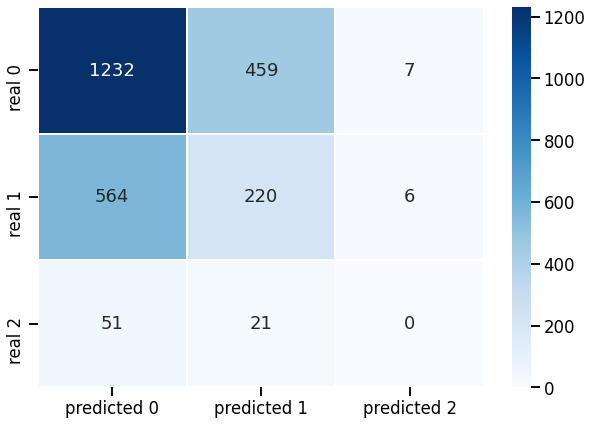

In [46]:
import seaborn as sn
sn.set_context("talk", font_scale=1.0)
df_cm = pd.DataFrame(cm_test, index = ['real 0', 'real 1', 'real 2'],
                  columns = ['predicted 0', 'predicted 1', 'predicted 2'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", linewidths=2, fmt='g')

In [47]:
feature_names = vectorizer.get_feature_names()
importances = classifier.coef_
importances_df = pd.DataFrame({'features' : feature_names, 'positive' : importances[0], 'negative' : importances[1], 'neutral' : importances[2]})
importances_df.set_index('features', inplace=True)

In [48]:
# Positive top features
importances_df.nlargest(15, 'positive')['positive']

features
הצלחה      4.086429
יחי        2.233256
אמן        2.185848
איש        2.085127
תצליח      1.782197
שבת        1.727129
ראוי       1.723326
נקרע       1.684209
יישר       1.660917
צלח        1.646370
ברכות      1.587959
נשבר       1.550502
סבא        1.540222
ישר        1.530756
מתלהמים    1.499845
Name: positive, dtype: float64

In [49]:
# Negative top features
importances_df.nlargest(15, 'negative')['negative']

features
מתבייש      3.151026
התבוללות    3.138179
ערבי        2.489791
מכות        1.922325
יהודי       1.919653
התאסלמה     1.866661
אכזבת       1.865211
מחבלים      1.810407
תפסיק       1.805302
עזה         1.800269
תיקה        1.658080
ראדי        1.647407
אבו         1.585421
מדאיג       1.572422
תחזור       1.556860
Name: negative, dtype: float64

In [50]:
importances_df.nlargest(15, 'neutral')['neutral']

features
גאי      3.988264
ייק      2.427955
נכים     1.901650
שמיטה    1.899104
מזמן     1.780540
שמירה    1.697467
דף       1.585510
מחיר     1.569939
חברים    1.388772
יגיע     1.261077
שונים    1.254785
יהוה     1.237901
חתן      1.208659
דניאל    1.105308
חובה     1.099788
Name: neutral, dtype: float64